**Colab Setup (GPU + Install)**

In [1]:
!nvidia-smi
!pip -q install pycocotools

Wed Dec 24 07:07:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os, json, random, numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import functional as F
from pycocotools.coco import COCO


**Define COCO Dataset for Faster R-CNN**

This reads your COCO JSON and returns targets in the format Faster R-CNN expects.

In [3]:
class COCODetectionFasterRCNN(Dataset):
    def __init__(self, images_dir, ann_file, transforms=None, category_ids=None):
        """
        images_dir: folder with images
        ann_file: path to COCO json
        category_ids: optional list of category ids to keep (e.g., [1,2,3])
        """
        self.images_dir = images_dir
        self.coco = COCO(ann_file)
        self.transforms = transforms

        self.img_ids = sorted(self.coco.getImgIds())

        # Optionally filter images to those containing selected categories
        self.category_ids = category_ids
        if self.category_ids is not None:
            keep = []
            for img_id in self.img_ids:
                ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)
                if len(ann_ids) > 0:
                    keep.append(img_id)
            self.img_ids = keep

        # Build COCO cat_id -> contiguous label (1..K); 0 is background
        cat_ids_all = self.category_ids if self.category_ids is not None else sorted(self.coco.getCatIds())
        self.cat_id_to_label = {cat_id: i+1 for i, cat_id in enumerate(cat_ids_all)}
        self.label_to_cat_id = {v: k for k, v in self.cat_id_to_label.items()}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.images_dir, img_info["file_name"])

        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for a in anns:
            # COCO bbox: [x, y, w, h]
            x, y, w, h = a["bbox"]
            if w <= 1 or h <= 1:
                continue

            cat_id = a["category_id"]
            if self.category_ids is not None and cat_id not in self.category_ids:
                continue

            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_id_to_label[cat_id])
            areas.append(a.get("area", w*h))
            iscrowd.append(a.get("iscrowd", 0))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "area": areas,
            "iscrowd": iscrowd
        }

        # If no boxes exist, keep empty tensors (Faster R-CNN can handle)
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target


**Transforms + Collate Function**

In [4]:
def get_train_transform():
    # Faster R-CNN in torchvision expects tensor images
    def _tf(img):
        img = F.to_tensor(img)
        return img
    return _tf

def get_val_transform():
    def _tf(img):
        img = F.to_tensor(img)
        return img
    return _tf

def collate_fn(batch):
    return tuple(zip(*batch))


**Point to Your COCO Paths**

In [5]:
TRAIN_IMAGES_DIR = "/content/drive/MyDrive/Ship Detection from Aerial Image.v1-augmented-model.coco/train"
TRAIN_ANN_FILE   = "/content/drive/MyDrive/Ship Detection from Aerial Image.v1-augmented-model.coco/train/_annotations.coco.json"

VAL_IMAGES_DIR   = "/content/drive/MyDrive/Ship Detection from Aerial Image.v1-augmented-model.coco/valid"
VAL_ANN_FILE     = "/content/drive/MyDrive/Ship Detection from Aerial Image.v1-augmented-model.coco/valid/_annotations.coco.json"


**Create DataLoaders**

In [6]:
train_ds = COCODetectionFasterRCNN(TRAIN_IMAGES_DIR, TRAIN_ANN_FILE, transforms=get_train_transform())
val_ds   = COCODetectionFasterRCNN(VAL_IMAGES_DIR, VAL_ANN_FILE, transforms=get_val_transform())

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Number of classes = background + your categories
num_classes = 1 + len(train_ds.cat_id_to_label)
num_classes


loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


3

**Build Faster R-CNN (Pretrained Backbone)**

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # Pretrained Faster R-CNN with ResNet50-FPN backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Replace the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes).to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 203MB/s]


**Train Loop**

In [8]:
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.train()
    total_loss = 0.0

    for images, targets in loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    avg_loss = total_loss / max(1, len(loader))
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f}")
    return avg_loss


**(Optional but Recommended) COCO mAP Evaluation**


Torchvision has a reference evaluator, but it’s longer. If you want true COCO mAP (AP@[.50:.95]), I’ll provide the full evaluation script. For now, here’s a quick sanity-check inference evaluator (not mAP):

In [9]:
@torch.no_grad()
def run_inference_sample(model, dataset, device, n=3):
    model.eval()
    idxs = random.sample(range(len(dataset)), k=min(n, len(dataset)))
    for i in idxs:
        img, _ = dataset[i]
        pred = model([img.to(device)])[0]
        print("Pred boxes:", pred["boxes"][:5].cpu().numpy())
        print("Scores:", pred["scores"][:5].cpu().numpy())
        print("Labels:", pred["labels"][:5].cpu().numpy())
        print("-"*50)

run_inference_sample(model, val_ds, device, n=2)


Pred boxes: [[391.10464 105.34418 440.5235  196.32448]
 [342.06796 621.8476  352.5836  633.07935]
 [338.06122 625.25397 350.4122  635.9862 ]
 [401.8303  376.41135 484.62897 409.4329 ]
 [336.52283 628.1921  348.6343  638.3354 ]]
Scores: [0.6421211  0.58269477 0.5716047  0.5567727  0.5497737 ]
Labels: [1 2 2 2 2]
--------------------------------------------------
Pred boxes: [[ 60.31084  117.16549  136.96465  260.9297  ]
 [150.56696  182.58153  192.00127  286.43784 ]
 [ 49.93454  148.29875  114.346825 296.4952  ]
 [132.85718  240.67249  206.39949  279.9438  ]
 [611.72095  625.45306  639.8425   640.      ]]
Scores: [0.6261997  0.59647506 0.5861995  0.5798031  0.57227933]
Labels: [1 2 1 2 2]
--------------------------------------------------


**Run Training**

In [10]:
num_epochs = 10

train_losses = []
for epoch in range(1, num_epochs + 1):
    loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    train_losses.append(loss)
    lr_scheduler.step()

torch.save(model.state_dict(), "faster_rcnn_coco_custom.pth")
print("Saved: faster_rcnn_coco_custom.pth")


Epoch 1 | Train Loss: 0.2219
Epoch 2 | Train Loss: 0.1469
Epoch 3 | Train Loss: 0.1263
Epoch 4 | Train Loss: 0.1042
Epoch 5 | Train Loss: 0.0998
Epoch 6 | Train Loss: 0.0978
Epoch 7 | Train Loss: 0.0967
Epoch 8 | Train Loss: 0.0947
Epoch 9 | Train Loss: 0.0945
Epoch 10 | Train Loss: 0.0940
Saved: faster_rcnn_coco_custom.pth


**Install COCO eval deps (Colab)**

In [11]:
!pip -q install pycocotools

**COCO mAP Evaluation (torchvision-style → COCOeval)**

In [12]:
from pycocotools.cocoeval import COCOeval

@torch.no_grad()
def evaluate_coco_map(model, dataset, device, score_thresh=0.05, max_dets=300):
    """
    Returns COCO metrics: mAP@[.50:.95], AP50, AP75, AR1, AR10, AR100
    """
    model.eval()
    coco_gt = dataset.coco
    results = []

    for i in range(len(dataset)):
        img, _ = dataset[i]
        img_id = int(dataset.img_ids[i])

        pred = model([img.to(device)])[0]

        boxes = pred["boxes"].detach().cpu().numpy()
        scores = pred["scores"].detach().cpu().numpy()
        labels = pred["labels"].detach().cpu().numpy()

        keep = scores >= score_thresh
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        # Convert xyxy -> xywh for COCO
        for b, s, l in zip(boxes, scores, labels):
            x1, y1, x2, y2 = b.tolist()
            w, h = x2 - x1, y2 - y1

            # map contiguous label -> original COCO category id
            cat_id = int(dataset.label_to_cat_id[int(l)])

            results.append({
                "image_id": img_id,
                "category_id": cat_id,
                "bbox": [x1, y1, w, h],
                "score": float(s)
            })

    if len(results) == 0:
        # No predictions: return zeros safely
        return {
            "mAP": 0.0, "AP50": 0.0, "AP75": 0.0,
            "AR1": 0.0, "AR10": 0.0, "AR100": 0.0
        }

    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")

    coco_eval.params.maxDets = [1, 10, max_dets]  # standard is [1,10,100]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    stats = coco_eval.stats  # length 12 for bbox
    return {
        "mAP": float(stats[0]),   # AP@[.50:.95]
        "AP50": float(stats[1]),  # AP@0.50
        "AP75": float(stats[2]),  # AP@0.75
        "AR1": float(stats[6]),
        "AR10": float(stats[7]),
        "AR100": float(stats[8]),
    }


**Precision / Recall / F1 per epoch (IoU matching @0.50)**

This computes detection PRF by matching predictions to GT per image, per class, greedy matching by score.

In [13]:
def iou_xyxy(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0.0, xB - xA)
    interH = max(0.0, yB - yA)
    interArea = interW * interH

    areaA = max(0.0, boxA[2] - boxA[0]) * max(0.0, boxA[3] - boxA[1])
    areaB = max(0.0, boxB[2] - boxB[0]) * max(0.0, boxB[3] - boxB[1])

    union = areaA + areaB - interArea + 1e-9
    return interArea / union


@torch.no_grad()
def evaluate_precision_recall_f1(model, dataset, device, iou_thresh=0.5, score_thresh=0.5):
    """
    Micro-averaged Precision/Recall/F1 over the whole validation set.
    """
    model.eval()

    TP = 0
    FP = 0
    FN = 0

    for idx in range(len(dataset)):
        img, target = dataset[idx]
        gt_boxes = target["boxes"].numpy() if len(target["boxes"]) else np.zeros((0,4), dtype=np.float32)
        gt_labels = target["labels"].numpy() if len(target["labels"]) else np.zeros((0,), dtype=np.int64)

        pred = model([img.to(device)])[0]
        pb = pred["boxes"].detach().cpu().numpy()
        ps = pred["scores"].detach().cpu().numpy()
        pl = pred["labels"].detach().cpu().numpy()

        keep = ps >= score_thresh
        pb, ps, pl = pb[keep], ps[keep], pl[keep]

        # Track which GT boxes have been matched
        matched_gt = np.zeros((len(gt_boxes),), dtype=bool)

        # Sort predictions by score (descending)
        order = np.argsort(-ps)
        pb, pl = pb[order], pl[order]

        for pbox, plabel in zip(pb, pl):
            # match only same-class GT
            candidates = np.where((gt_labels == plabel) & (~matched_gt))[0]
            if candidates.size == 0:
                FP += 1
                continue

            # find best IoU among candidates
            best_iou = -1
            best_j = -1
            for j in candidates:
                iou = iou_xyxy(pbox, gt_boxes[j])
                if iou > best_iou:
                    best_iou = iou
                    best_j = j

            if best_iou >= iou_thresh:
                TP += 1
                matched_gt[best_j] = True
            else:
                FP += 1

        # Remaining unmatched GT are FN
        FN += int((~matched_gt).sum())

    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)

    return {
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "tp": int(TP),
        "fp": int(FP),
        "fn": int(FN),
    }


**Visualization: predictions after each epoch**

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

@torch.no_grad()
def visualize_predictions(model, dataset, device, n=3, score_thresh=0.5):
    model.eval()
    idxs = random.sample(range(len(dataset)), k=min(n, len(dataset)))

    for idx in idxs:
        img, target = dataset[idx]
        pred = model([img.to(device)])[0]

        # tensor -> HWC image
        im = img.permute(1,2,0).cpu().numpy()

        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax.imshow(im)
        ax.set_title(f"Predictions (score >= {score_thresh})")
        ax.axis("off")

        boxes = pred["boxes"].detach().cpu().numpy()
        scores = pred["scores"].detach().cpu().numpy()
        labels = pred["labels"].detach().cpu().numpy()

        keep = scores >= score_thresh
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        for b, s, l in zip(boxes[:30], scores[:30], labels[:30]):  # limit to 30 boxes
            x1, y1, x2, y2 = b
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, fill=False)
            ax.add_patch(rect)
            ax.text(x1, y1, f"cls:{int(l)} {s:.2f}", fontsize=10,
                    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

        plt.show()


**Plot training curves (loss + PRF + mAP)**

In [15]:
def plot_history(history):
    # history keys expected: train_loss, precision, recall, f1, mAP, AP50, AP75
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(list(epochs), history["train_loss"], marker='o')
    plt.title("Train Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # PRF
    plt.figure(figsize=(8,5))
    plt.plot(list(epochs), history["precision"], marker='o', label="Precision")
    plt.plot(list(epochs), history["recall"], marker='o', label="Recall")
    plt.plot(list(epochs), history["f1"], marker='o', label="F1")
    plt.title("Precision / Recall / F1 per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.show()

    # mAP
    plt.figure(figsize=(8,5))
    plt.plot(list(epochs), history["mAP"], marker='o', label="mAP@[.50:.95]")
    plt.plot(list(epochs), history["AP50"], marker='o', label="AP50")
    plt.plot(list(epochs), history["AP75"], marker='o', label="AP75")
    plt.title("COCO mAP per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.grid(True)
    plt.legend()
    plt.show()


**training loop with this upgraded loop**

Epoch 1 | Train Loss: 0.0943
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.626
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.778
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.624
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.643
 Average Recall     (AR) @[ IoU=0.50:0

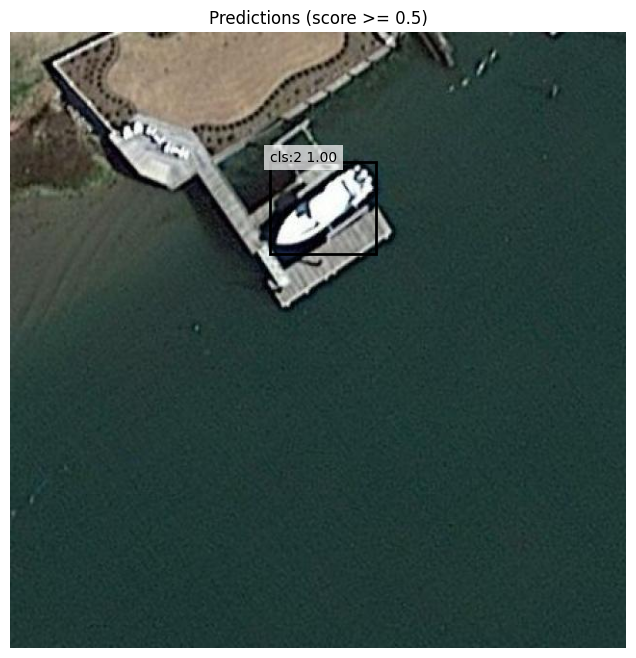

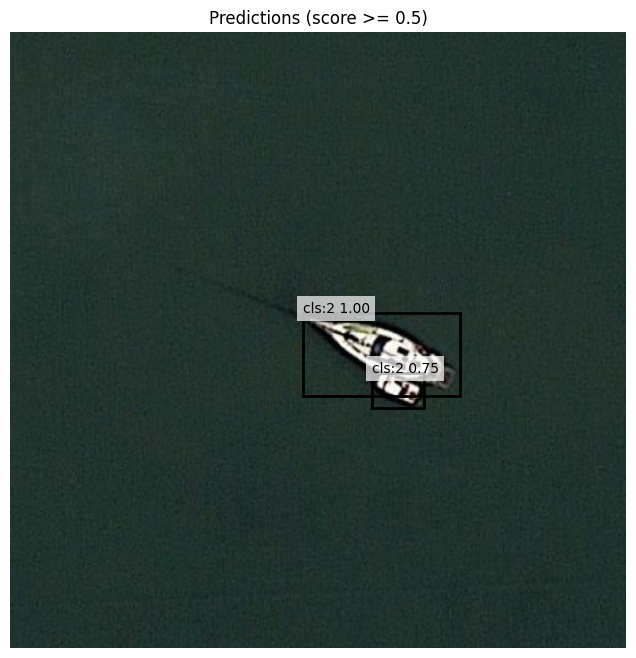

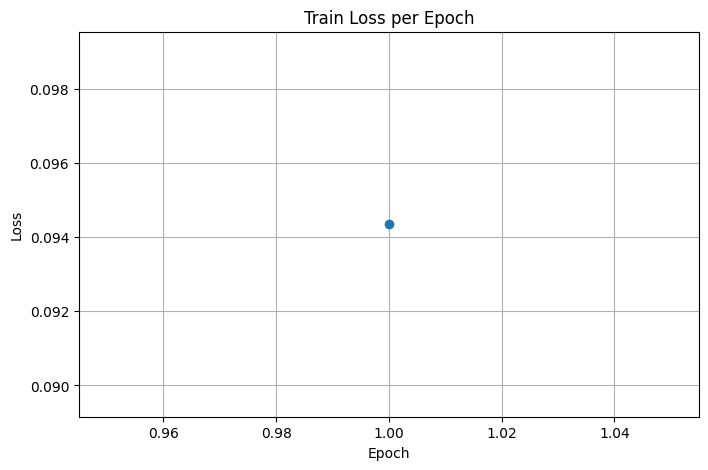

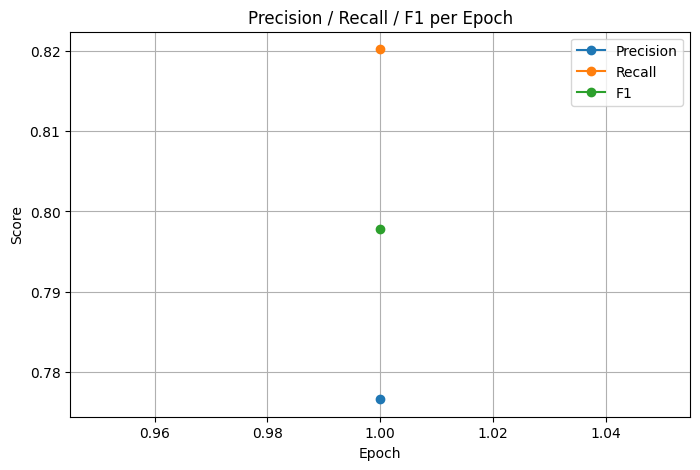

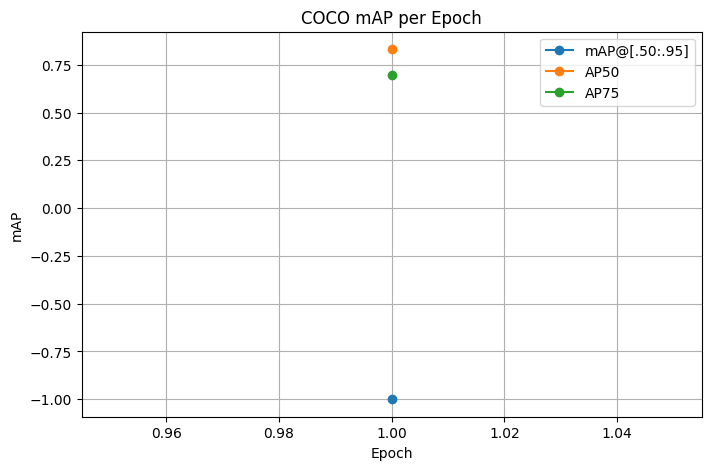

Epoch 2 | Train Loss: 0.0944
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0

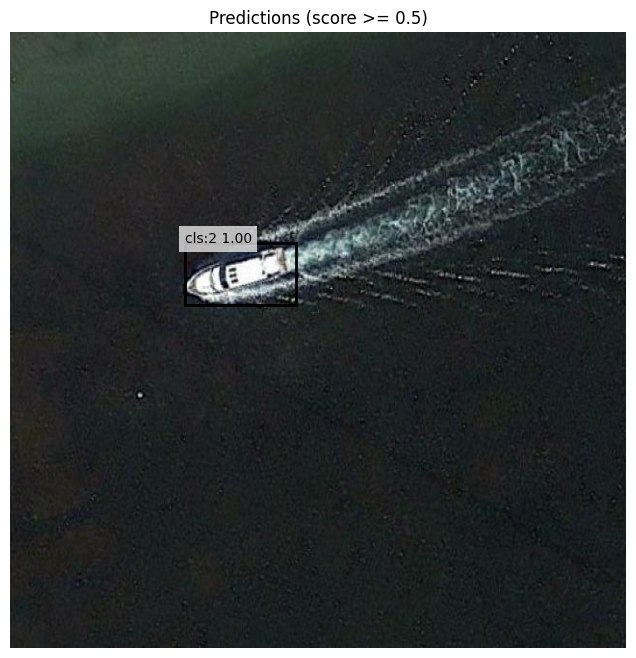

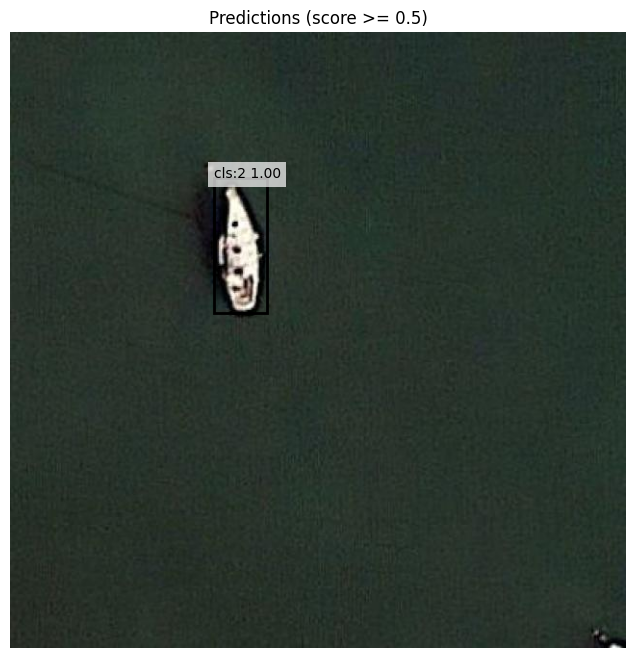

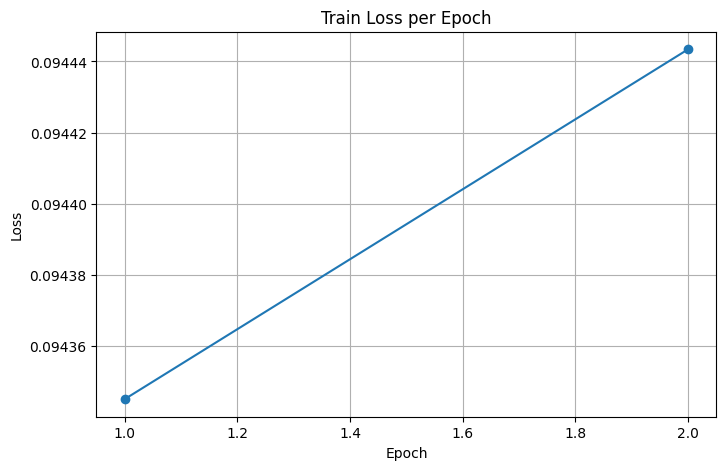

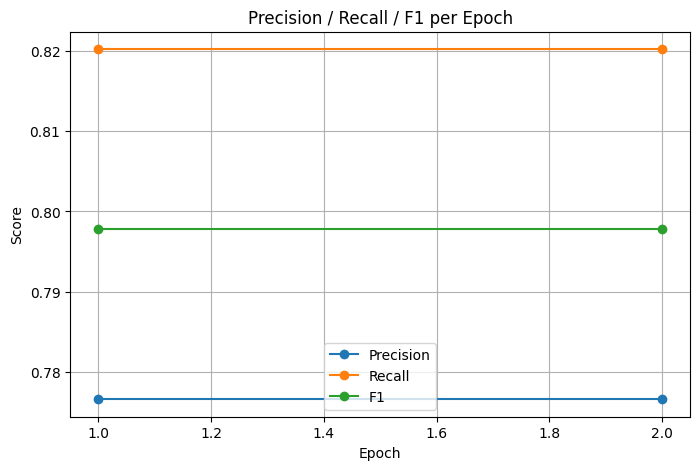

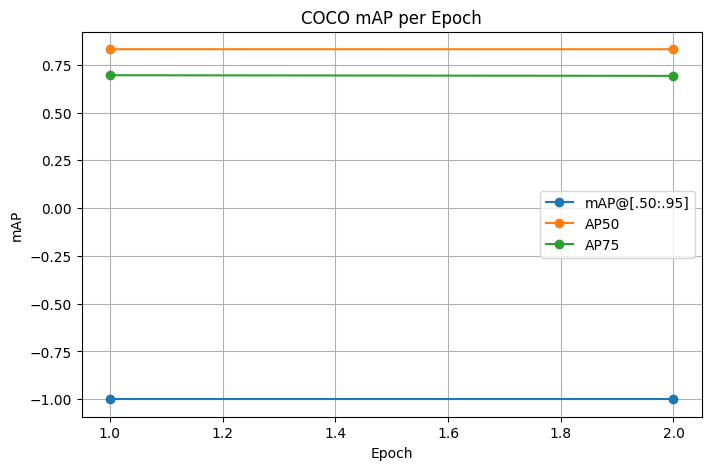

Epoch 3 | Train Loss: 0.0944
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0

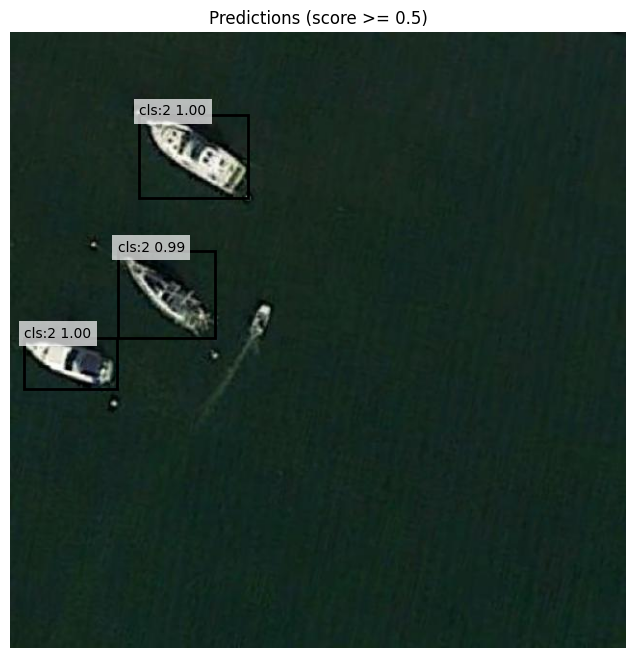

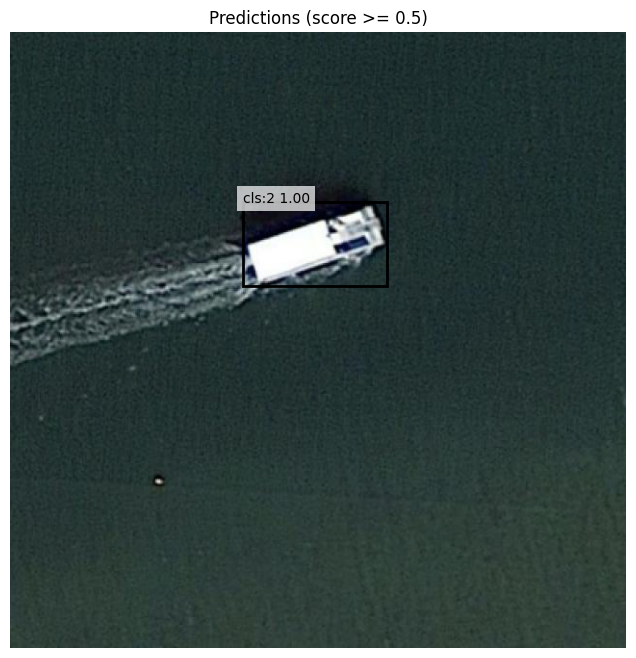

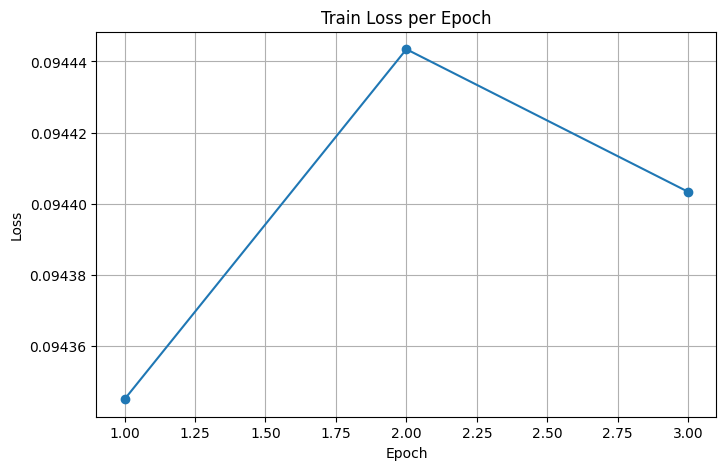

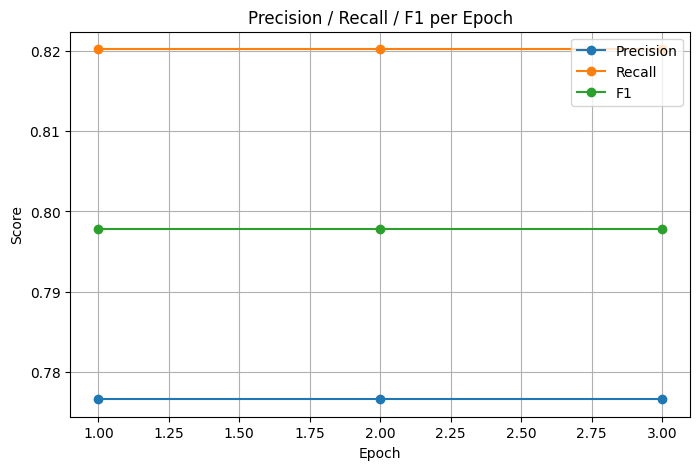

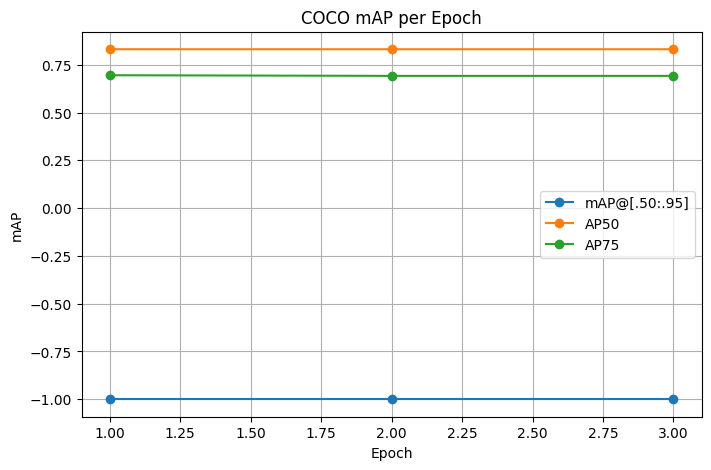

Epoch 4 | Train Loss: 0.0940
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0

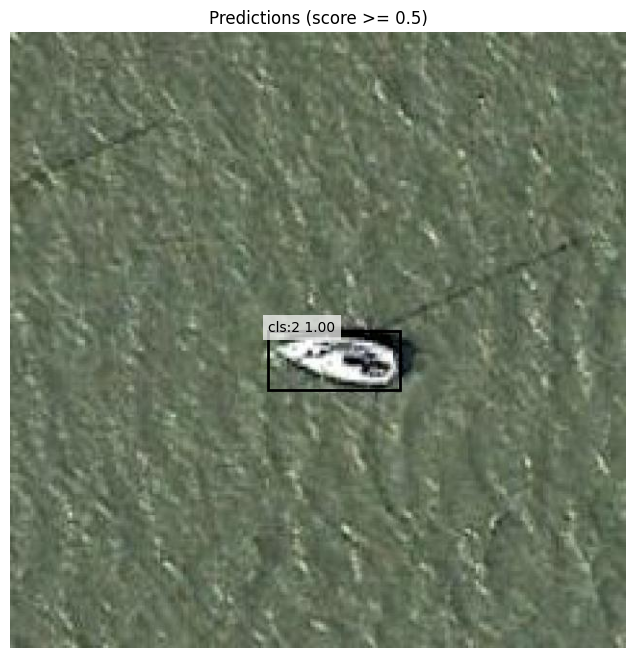

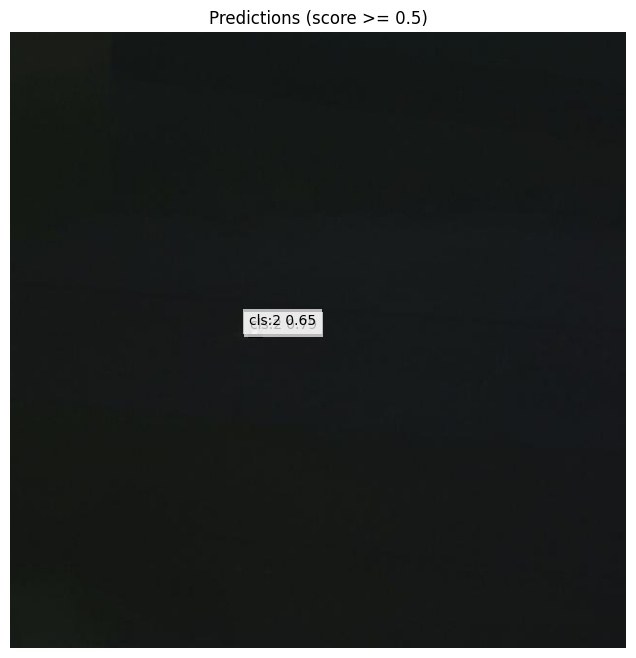

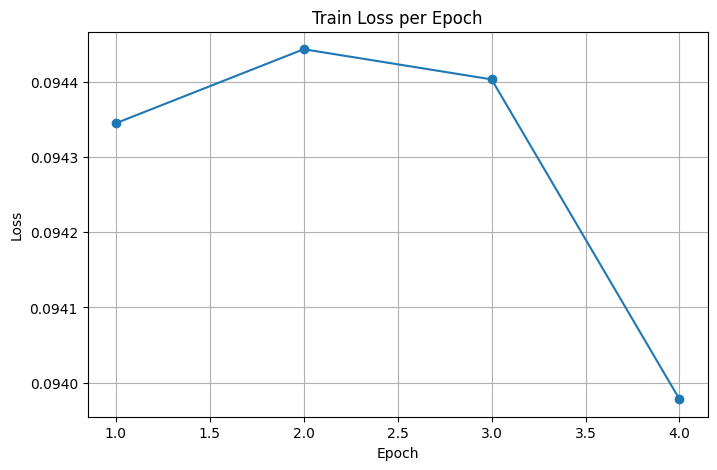

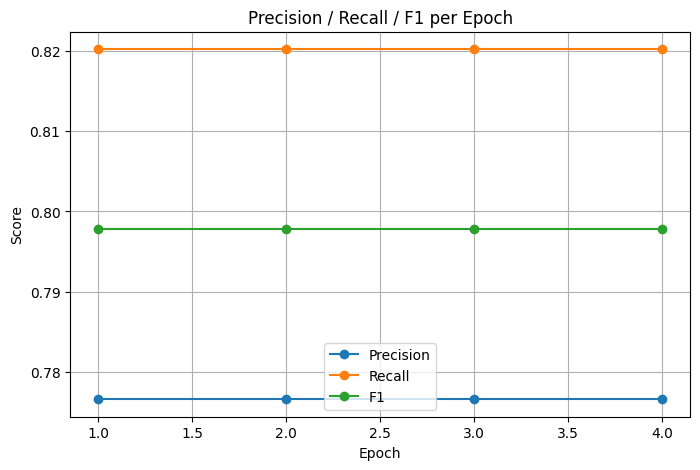

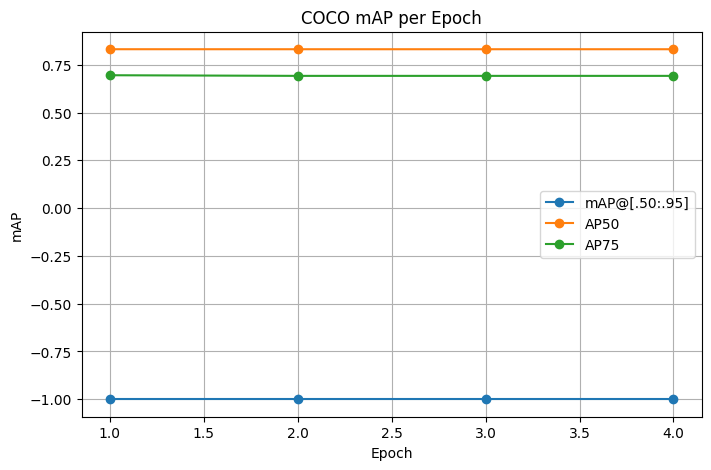

Epoch 5 | Train Loss: 0.0942
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0

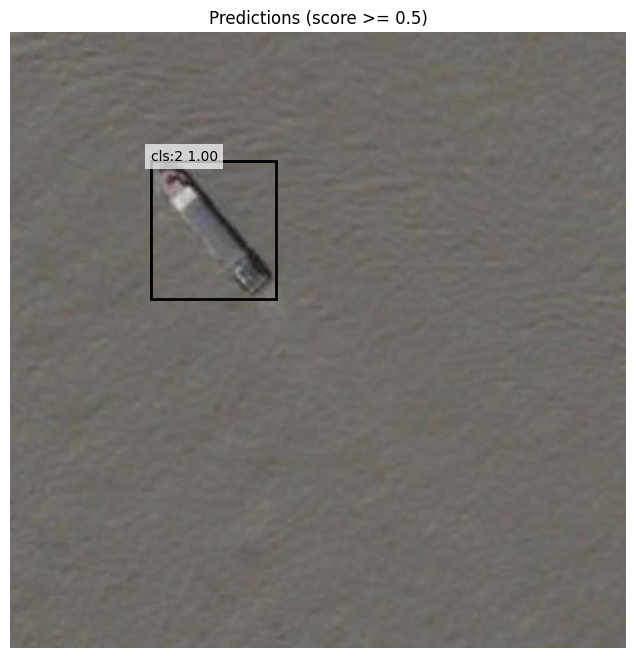

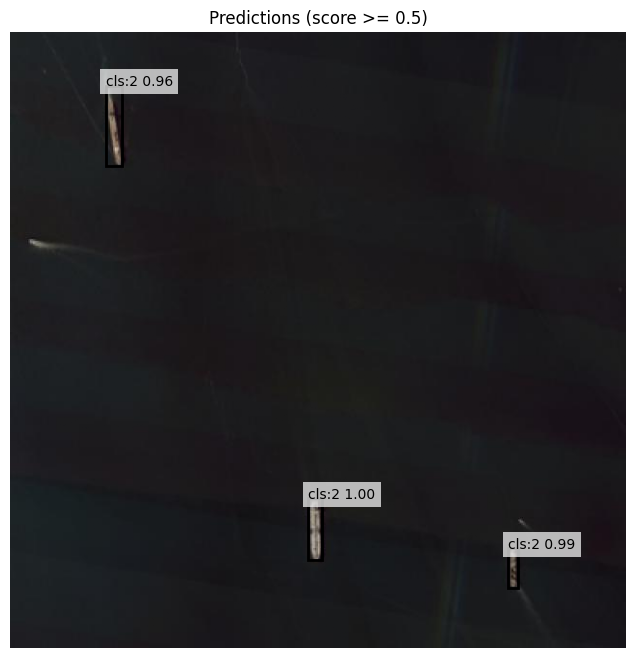

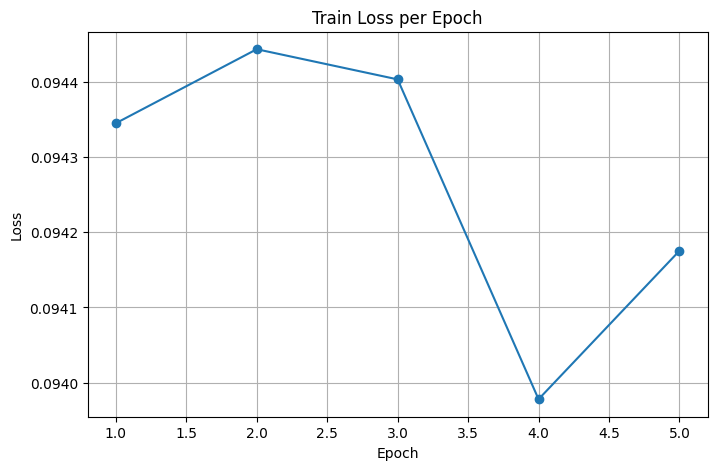

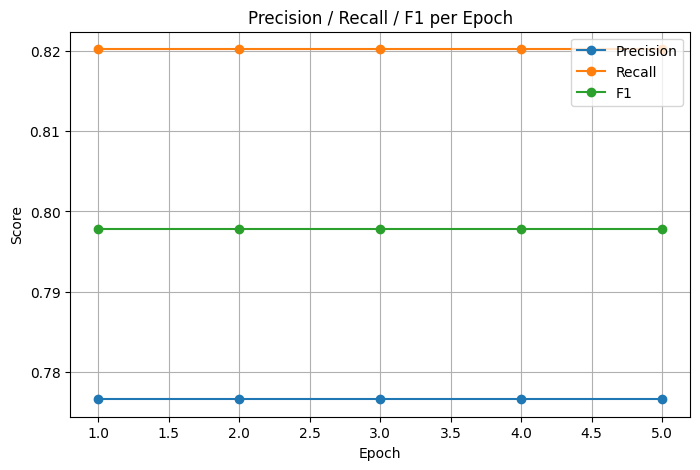

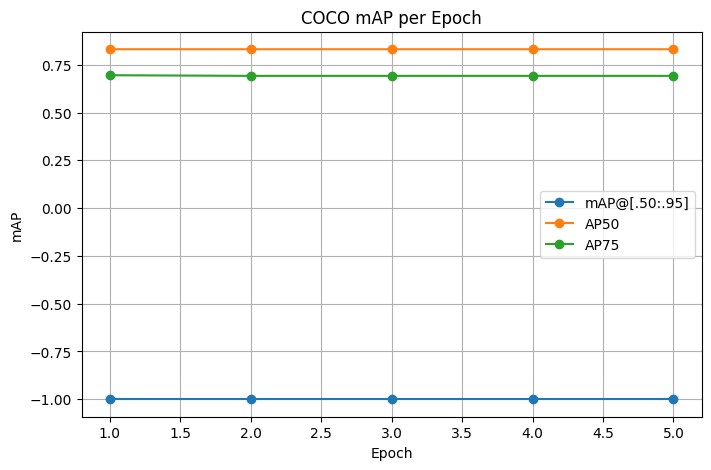

Epoch 6 | Train Loss: 0.0944
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0

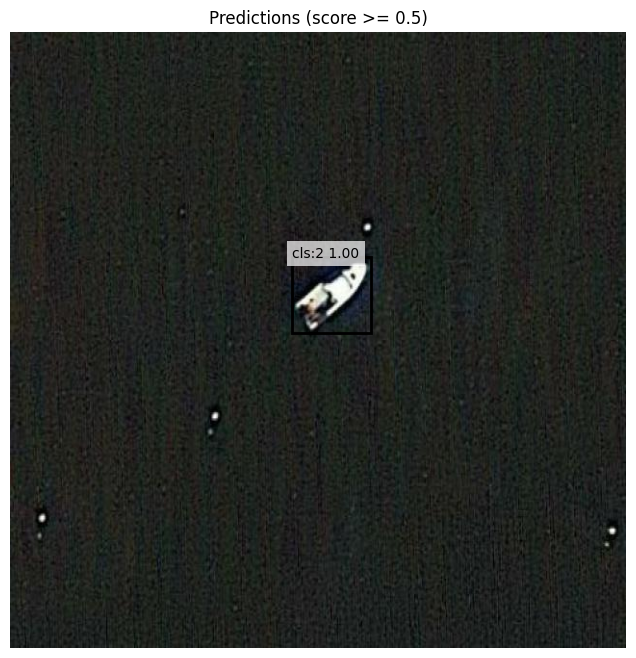

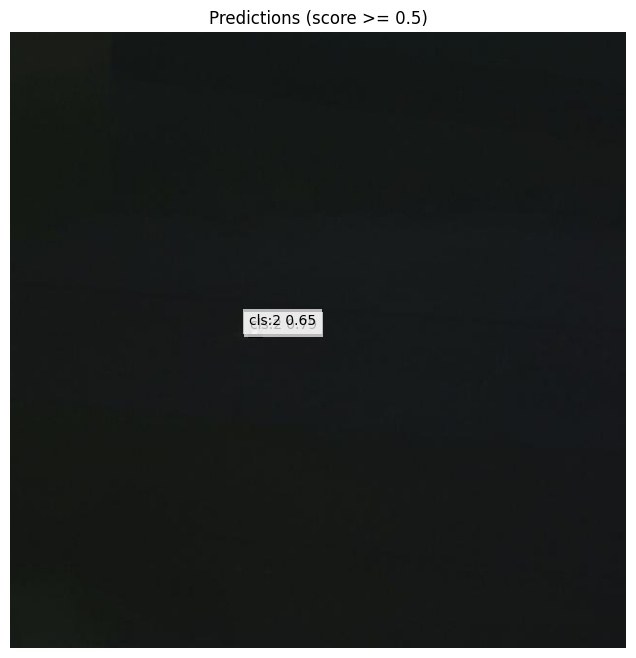

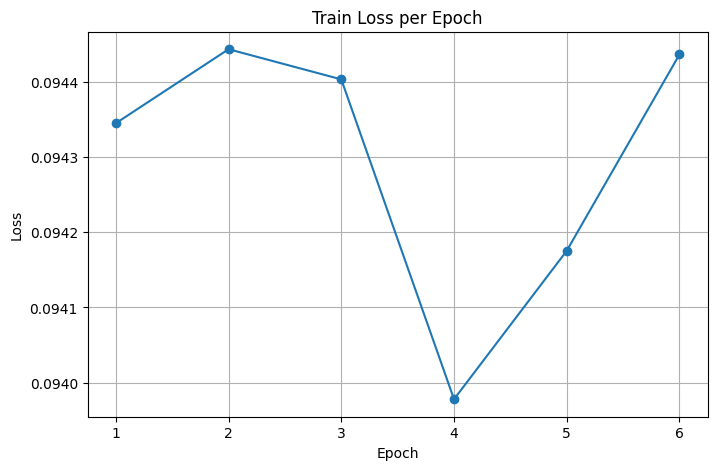

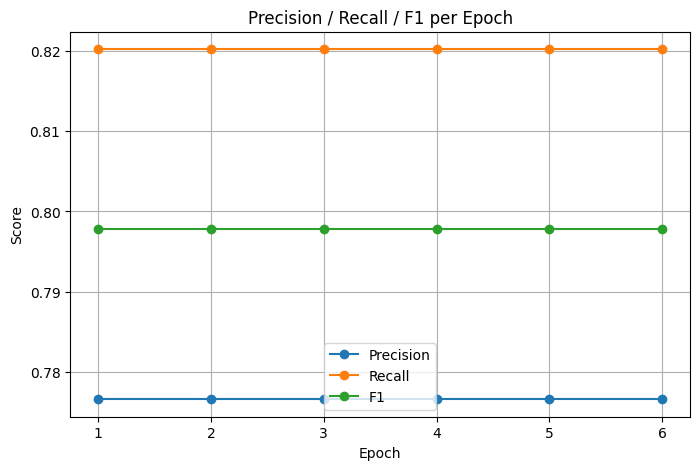

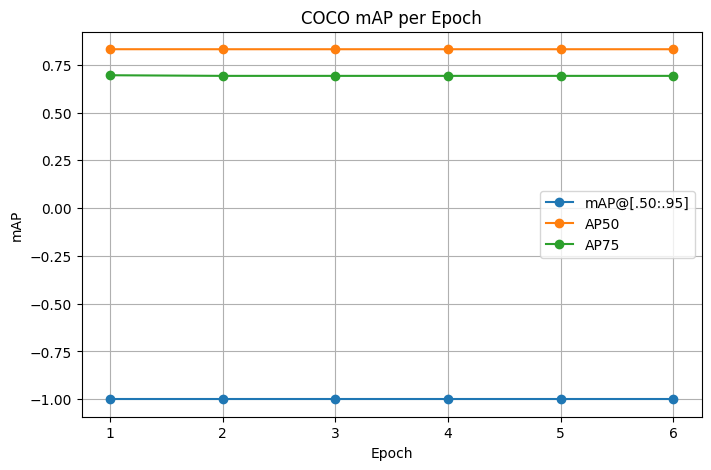

Epoch 7 | Train Loss: 0.0953
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0

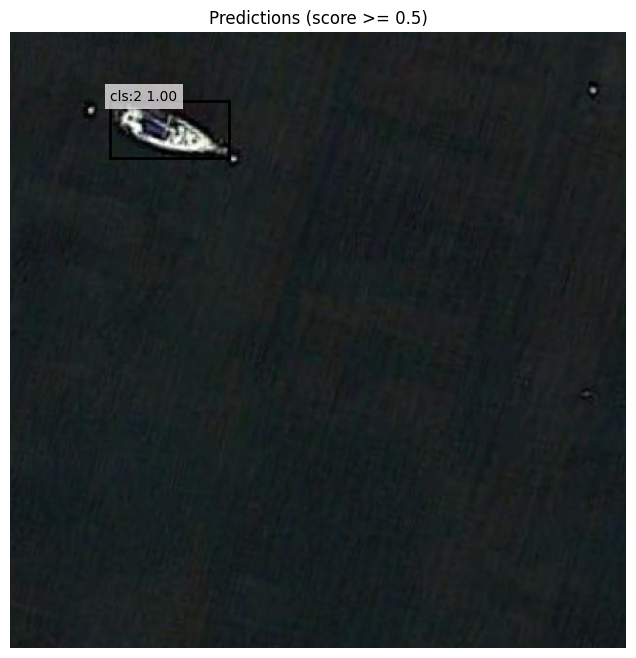

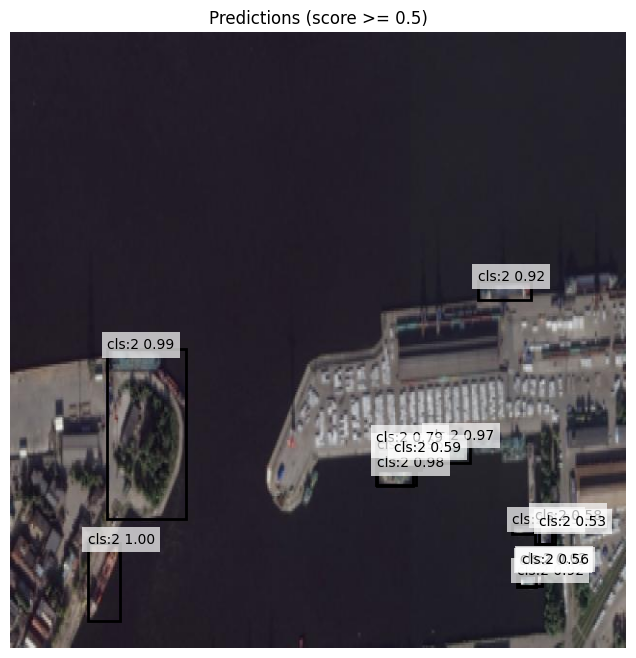

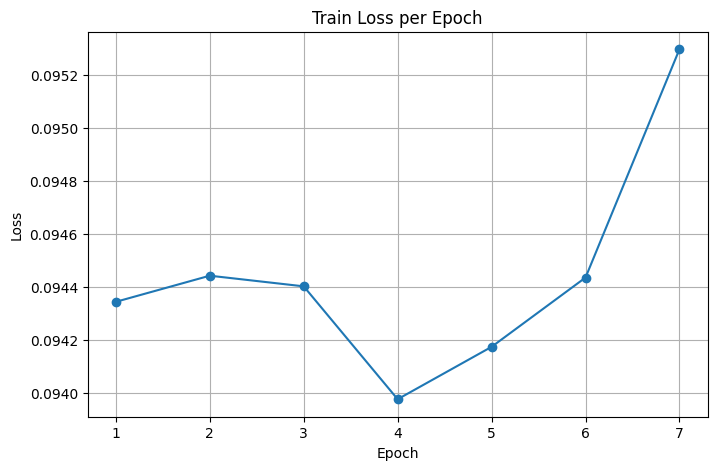

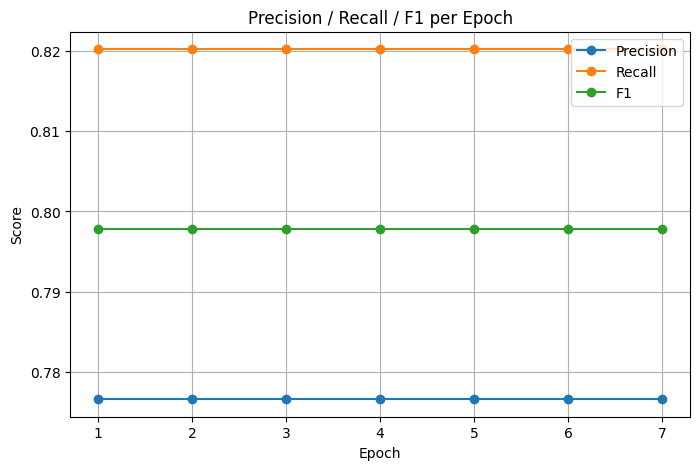

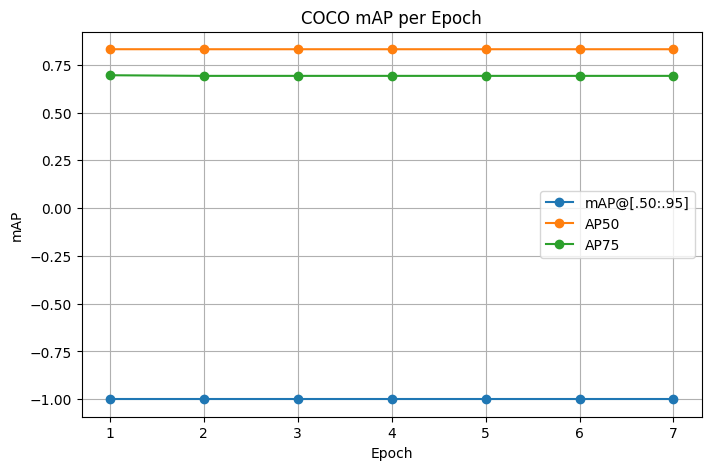

Epoch 8 | Train Loss: 0.0941
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0

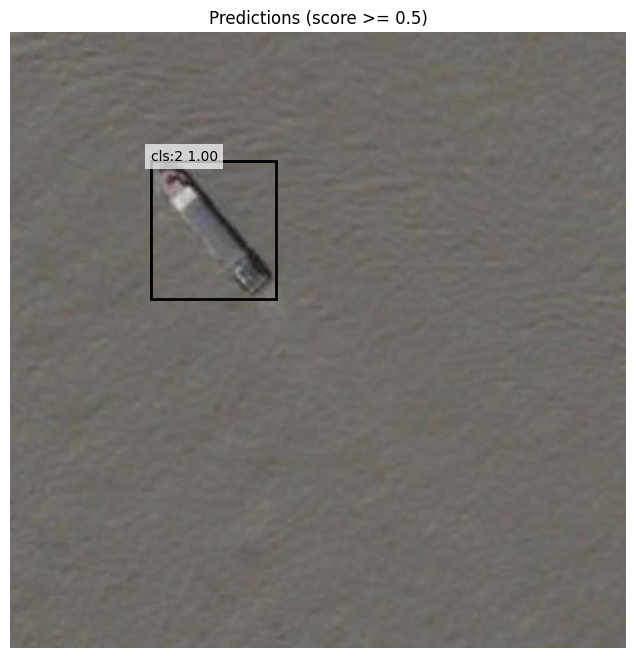

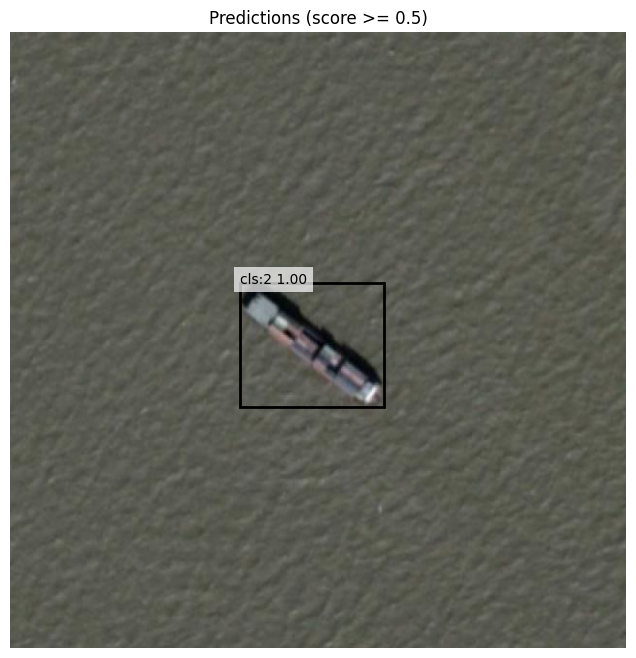

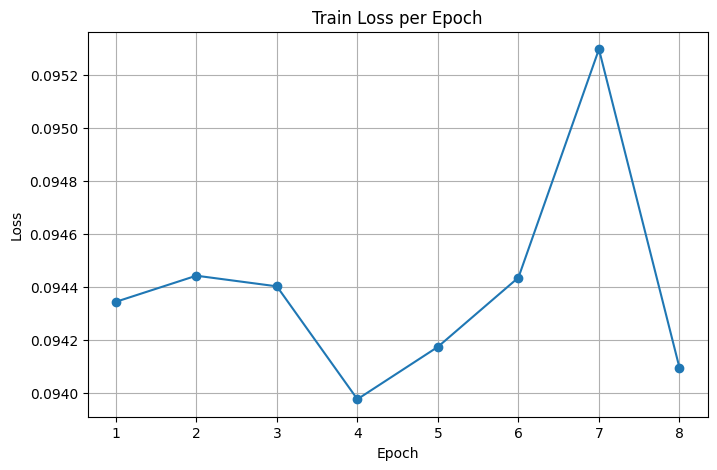

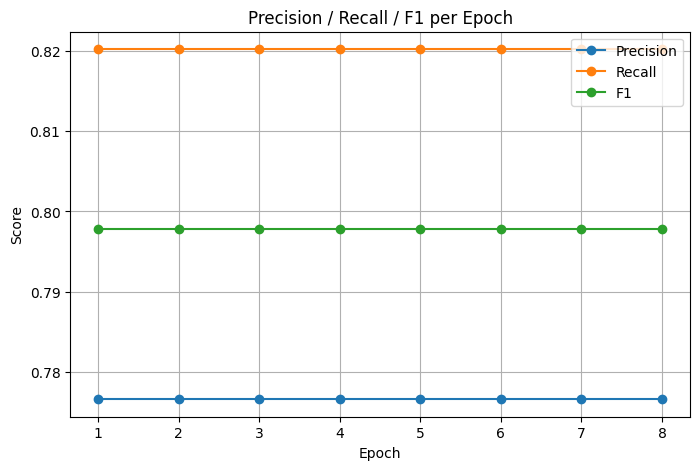

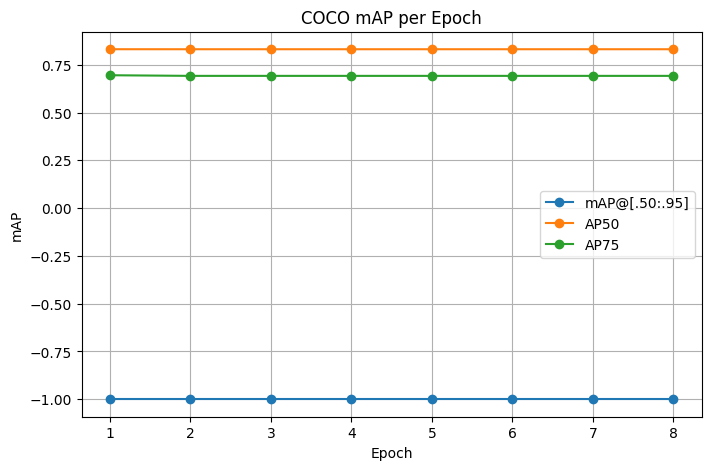

Epoch 9 | Train Loss: 0.0940
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0

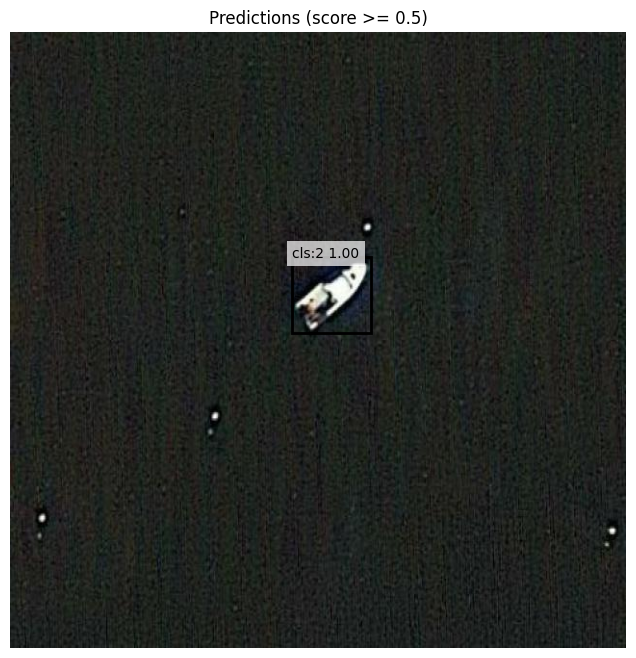

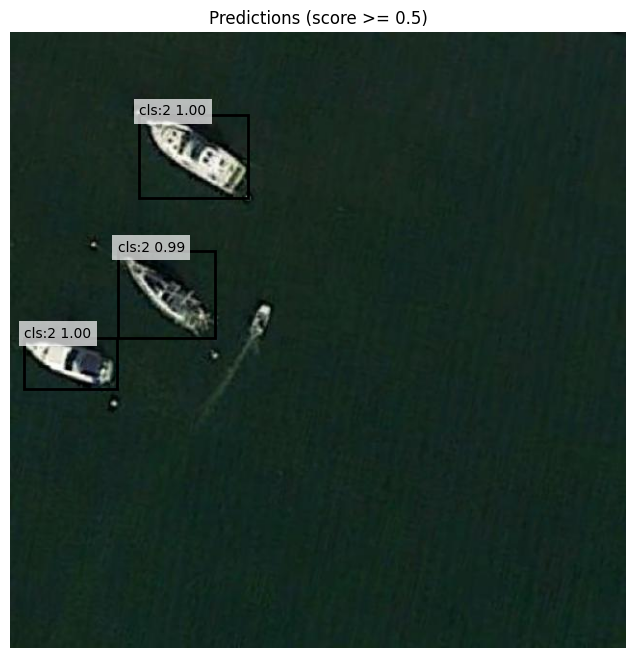

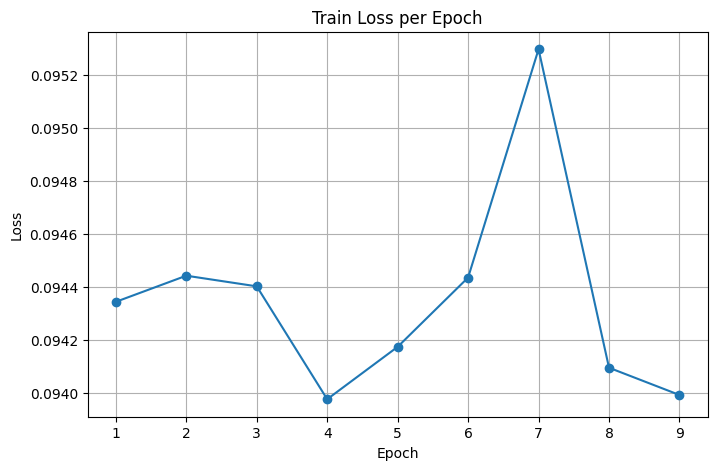

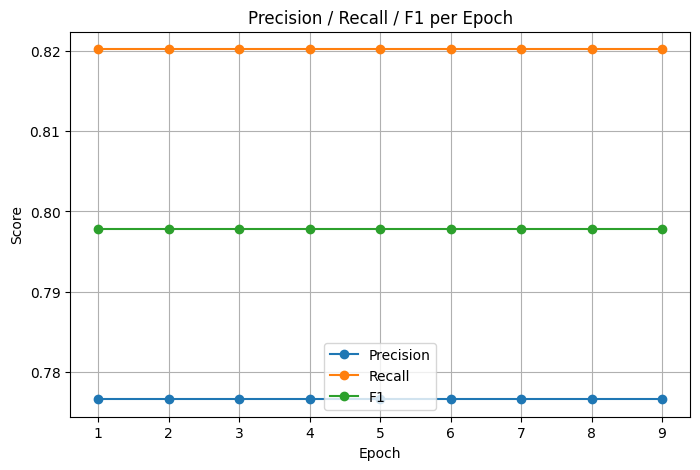

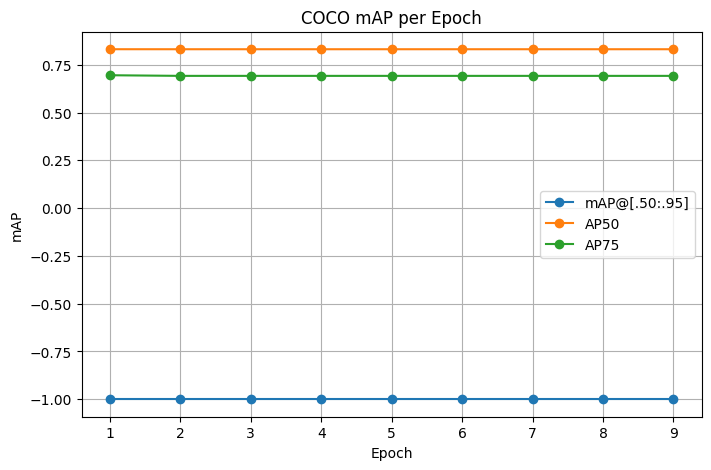

Epoch 10 | Train Loss: 0.0946
Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:

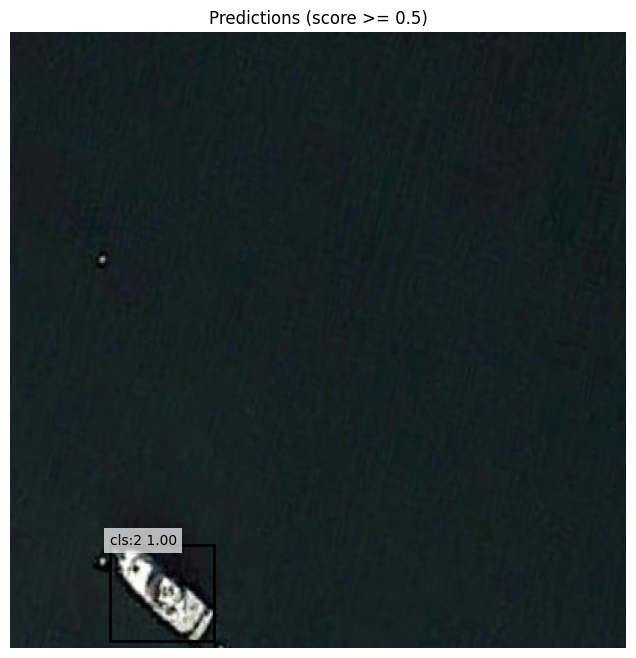

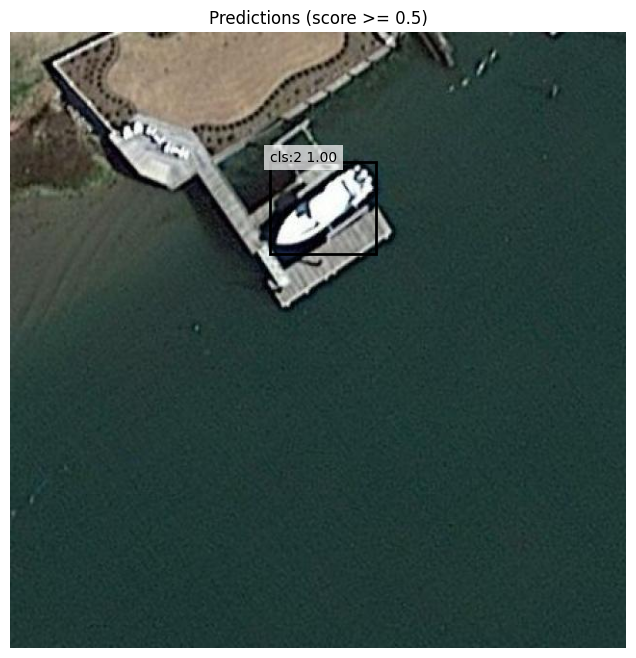

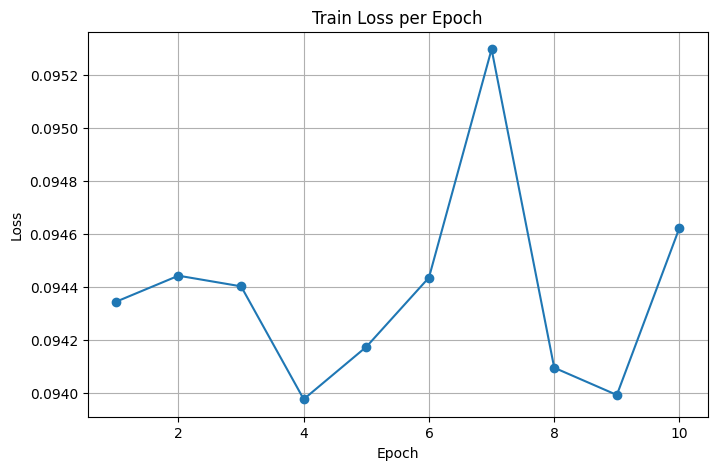

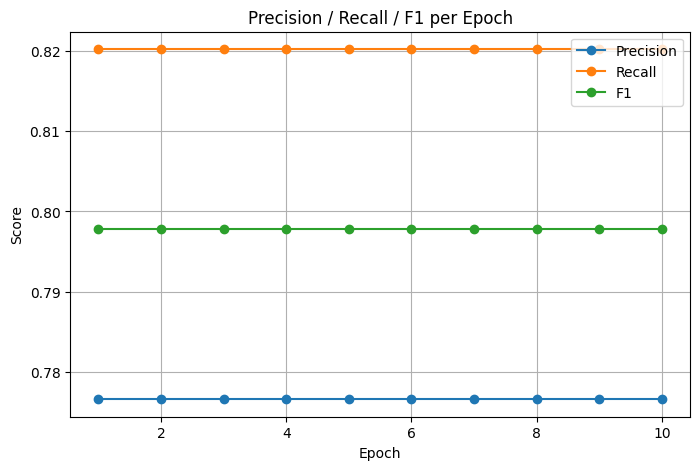

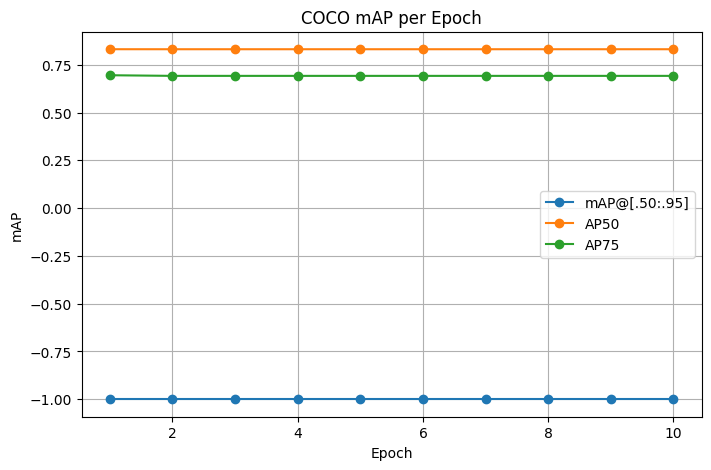

Saved final: faster_rcnn_coco_custom_final.pth


In [16]:
import time

num_epochs = 10

history = {
    "train_loss": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "mAP": [],
    "AP50": [],
    "AP75": []
}

best_map = -1.0

# thresholds
pr_iou_thresh = 0.50
pr_score_thresh = 0.50

coco_score_thresh = 0.05  # standard for COCO eval

for epoch in range(1, num_epochs + 1):
    t0 = time.time()

    # 1) Train
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    history["train_loss"].append(train_loss)
    lr_scheduler.step()

    # 2) PRF on validation
    prf = evaluate_precision_recall_f1(
        model=model,
        dataset=val_ds,
        device=device,
        iou_thresh=pr_iou_thresh,
        score_thresh=pr_score_thresh
    )

    history["precision"].append(prf["precision"])
    history["recall"].append(prf["recall"])
    history["f1"].append(prf["f1"])

    # 3) COCO mAP on validation
    coco_metrics = evaluate_coco_map(model, val_ds, device, score_thresh=coco_score_thresh)
    history["mAP"].append(coco_metrics["mAP"])
    history["AP50"].append(coco_metrics["AP50"])
    history["AP75"].append(coco_metrics["AP75"])

    # 4) Print epoch summary
    dt = time.time() - t0
    print(f"\nEpoch {epoch}/{num_epochs} Summary (time: {dt:.1f}s)")
    print(f"  Train Loss     : {train_loss:.4f}")
    print(f"  Precision@{pr_score_thresh:.2f} : {prf['precision']:.4f}")
    print(f"  Recall@{pr_score_thresh:.2f}    : {prf['recall']:.4f}")
    print(f"  F1@{pr_score_thresh:.2f}        : {prf['f1']:.4f}")
    print(f"  COCO mAP        : {coco_metrics['mAP']:.4f}")
    print(f"  AP50            : {coco_metrics['AP50']:.4f}")
    print(f"  AP75            : {coco_metrics['AP75']:.4f}")

    # 5) Save best model by mAP
    if coco_metrics["mAP"] > best_map:
        best_map = coco_metrics["mAP"]
        torch.save(model.state_dict(), "faster_rcnn_best_map.pth")
        print("  Saved best model: faster_rcnn_best_map.pth")

    # 6) Visualize predictions each epoch (optional)
    visualize_predictions(model, val_ds, device, n=2, score_thresh=0.5)

    # 7) Plot curves so far
    plot_history(history)

# Save final
torch.save(model.state_dict(), "faster_rcnn_coco_custom_final.pth")
print("Saved final: faster_rcnn_coco_custom_final.pth")
